In [17]:
import sys
sys.path.insert(0, "..")
import utils
import numpy as np

# read and process dataset
data = utils.load_dataset("../data/mit_Uferuebergang/all_data_edit.txt")
dataset = utils.WaveFormDataset(data)
wfs = dataset[:]["waveform"].numpy()
print("dataset length=%s" % len(data))

dataset length=274047


## Clustering
* = Klassifizierung ohne Angabe von Labels
* Es sollen markante Unterschiede im Datensatz gelernt werden.
* Eine Möglichkeit: **K-Means.**

## K-Means
* Als Eingabe: eine Anzahl $N$ an Clusterzentren, die gefunden werden sollen.
* K-Means findet dann $N$ Punkte, die möglichst divers sind.
* Die Clusterzugehörigkeit (sprich Label) wird via Distanzmaß (z.B. euklidische Distanz) entschieden.


* Der Algorithmus verfährt wie folgt.
    * Es werden $N$ zufällige Clusterzentren initialisiert (in unserem Fall $c_1,\dots,c_N \in \mathbb{R}^{64}$).
    * Bestimmung der Clusterzugehörigkeit eines jeden Datenpunkts $p$:
    $$ c^*(p) = \arg\min_{c_k} \sqrt{\sum_{j=1}^{64} (c_k - p)^2} \quad \text{mit} \quad k=1,\dots,N $$
    * Verschiebung der Clusterzentren in die Richtung des Erwartungswerts der Punkte in diesem Cluster:
    $$ c_{i+1}(p) = \mathbb{E}[c^*_i(p)] $$ 
    * Algorithmus terminiert, wenn sich die Clusterzugehörigkeit nicht mehr ändert (oder bspw. eine maximale Anzahl an Iterationen überschritten worden ist). 
    
![kmeans](https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif)
Clustering mit 3 Clusterzentren. Quelle: Wikipedia/Chire

---
## Visualisierung der Clusterzentren

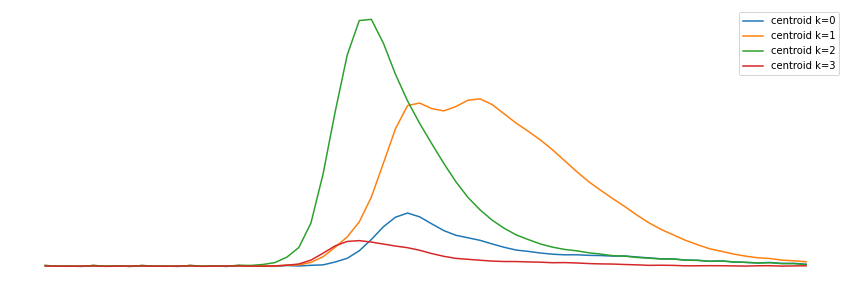

In [34]:
%matplotlib inline
from scipy.cluster.vq import kmeans2
clustercount = 4
initialcentroids = wfs[np.random.randint(len(wfs), size=clustercount)]
ks, labels = kmeans2(wfs, k=initialcentroids, minit="matrix")
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.axis('off')    
for idx, k in enumerate(ks):
    xs = np.arange(len(k))
    plt.plot(xs,k,label="centroid k=%d" % idx)    
plt.legend()

## Visualisierung der Cluster

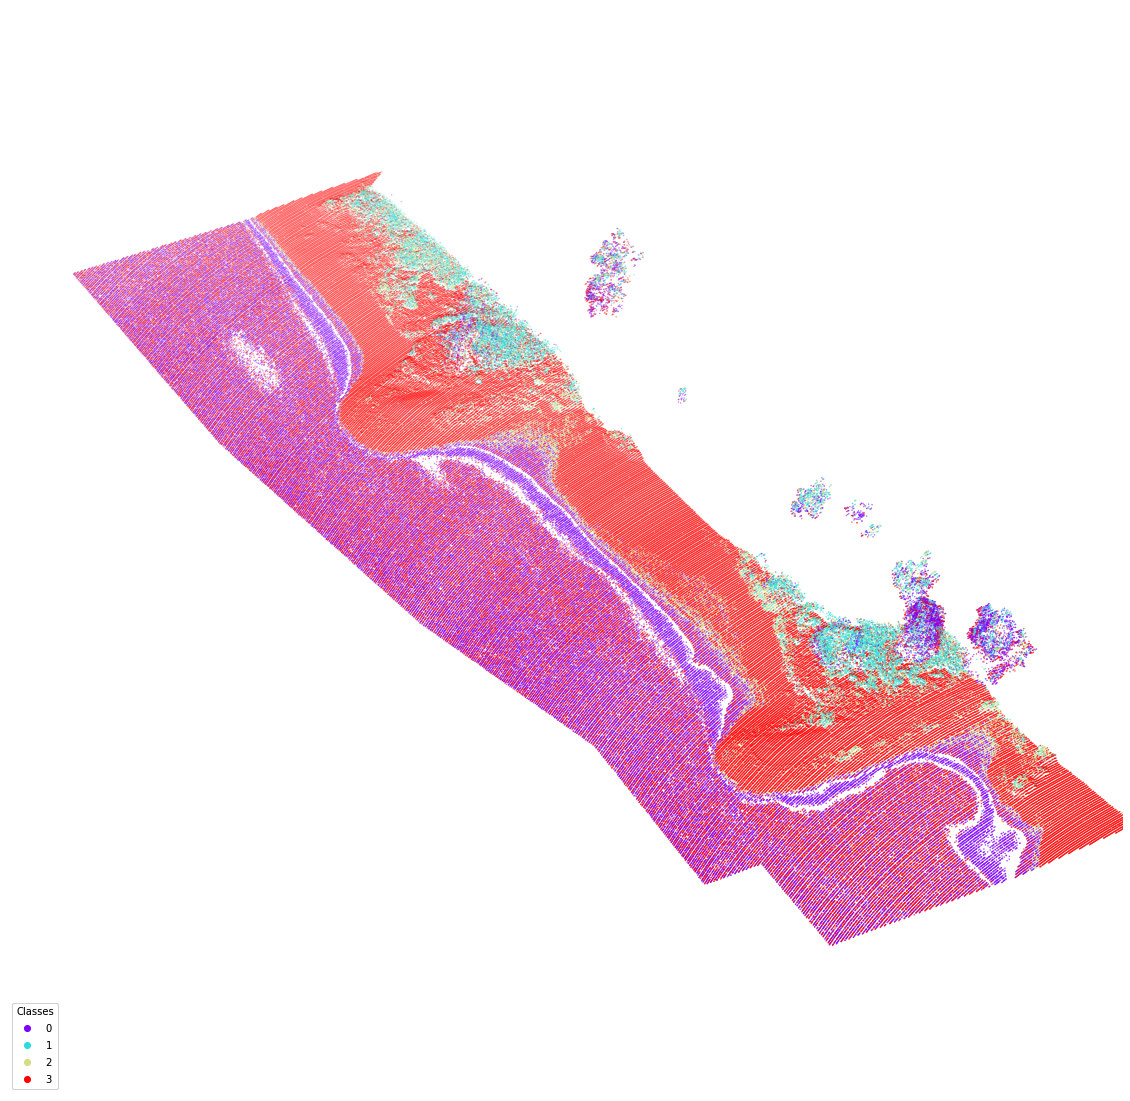

In [35]:
%matplotlib inline
datapredfull = data.assign(prediction = labels)
utils.plot_pcl(datapredfull, targetcol="prediction")

## Ergebnisse
* Es werden größtenteils sinnvolle Cluster gefunden. Da Wasser und Land aber relativ ähnlich sind, wird oft nicht richtig differenziert.
* Erhöhung der Clusteranzahl kann mehr Cluster finden, allerdings werden damit gleichartige Punkte getrennt.

## Probleme?
* Das Distanzmaß verliert an Bedeutung, je größer die Dimension ist (siehe u.a. [Fluch der Dimensionalität](https://de.wikipedia.org/wiki/Fluch_der_Dimensionalit%C3%A4t)).
* Einfluss der Dimensionen kann recht unterschiedlich sein,
* und andere weisen vielleicht eine hohe Korrelation auf (https://en.wikipedia.org/wiki/Clustering_high-dimensional_data).
* => Das soll vermieden werden, indem bspw. eine Dimensionsreduktion durchgeführt wird.
    

## Autoencoder
* Ein KNN, das eine effiziente Kodierung der Eingabedaten lernen soll.
* Dazu wird eine Encoderfunktion $h$ und eine Decodierfunktion $g$ gelernt.
* Die Besonderheit ist, dass die Dimension des "Codes" deutlich kleiner ist, als die Dimension der Daten (z.B. 8 bei einer Eingabedimension von 64).


<img src="https://miro.medium.com/max/3524/1*oUbsOnYKX5DEpMOK3pH_lg.png" width="50%"><div align="center">Quelle: [Comprehensive Introduction to Autoencoders](https://towardsdatascience.com/generating-images-with-autoencoders-77fd3a8dd368)</div></img>

* Das KNN wird in der einfachsten Form unüberwacht trainiert. Die Kostenfunktion ist dabei so ausgelegt, dass die Ausgabe des KNNs möglichst der Eingabe entsprechen soll:

$$ (h^*, g^*) = \arg\min_{(h,g) \in H \times G} \frac{1}{n} \sum_{i=1}^{n} || x_i - g(h(x_i)) ||^2 $$

* In unserem Beispiel entsprechen dann Eingabe und Ausgabe den Wave-Forms.

---
## Autoencoder für Clustering
* Nach der Dimensionsreduktion kann ein einfacher Clusteringalgorithmus wie K-Means verwendet werden, um die Wave-Forms in Cluster zu gruppieren:

In [2]:
import sys
sys.path.insert(0, "..")
import utils
import numpy as np

# read and process dataset
data = utils.load_dataset("../data/mit_Uferuebergang/all_data_edit.txt")
dataset = utils.WaveFormDataset(data)
wfs = dataset[:]["waveform"].numpy()
print("dataset length=%s" % len(data))

from utils import AutoEncoder, AETrainer
import torch

dataset length=274047


## Training

Wir trainieren den Autoencoder auf dem kompletten Datensatz für 50 Epochen. Dabei wird eine Zwischendimension von 8 verwendet. Die Parameter `sparsity` bzw. `weight_decay` fügen weitere Kostenterme für hohe Zwischenrepräsentationswerte bzw. Gewichtungsmatritzen hinzu.

In [3]:
aedim = 8
ac = AutoEncoder(dimensions=aedim)
trainer = AETrainer(ac,epochs=50, weight_decay=1e-6, sparsity=1e-6, batch_size=2048)
trainer.set_dataset(dataset)
for epoch in trainer.train():
    print(epoch)

{'epoch': 0, 'mean_loss': 0.007966616937567382}
{'epoch': 1, 'mean_loss': 0.0026307331055618268}
{'epoch': 2, 'mean_loss': 0.001708405042328864}
{'epoch': 3, 'mean_loss': 0.0013708815503911658}
{'epoch': 4, 'mean_loss': 0.0012599342494956723}
{'epoch': 5, 'mean_loss': 0.001128696400695288}
{'epoch': 6, 'mean_loss': 0.0009245969300266077}
{'epoch': 7, 'mean_loss': 0.0008597264252987899}
{'epoch': 8, 'mean_loss': 0.0008293700453532812}
{'epoch': 9, 'mean_loss': 0.0008101431731796584}
{'epoch': 10, 'mean_loss': 0.0007971316255621361}
{'epoch': 11, 'mean_loss': 0.0007816453547070712}
{'epoch': 12, 'mean_loss': 0.0007671524774406316}
{'epoch': 13, 'mean_loss': 0.0007545221005258543}
{'epoch': 14, 'mean_loss': 0.0007425411161774203}
{'epoch': 15, 'mean_loss': 0.0007274967723156611}
{'epoch': 16, 'mean_loss': 0.0007063598855021449}
{'epoch': 17, 'mean_loss': 0.0006823423727461682}
{'epoch': 18, 'mean_loss': 0.0006607623125257137}
{'epoch': 19, 'mean_loss': 0.000637727383570361}
{'epoch': 20, 

## Rekonstruktionsfähigkeit

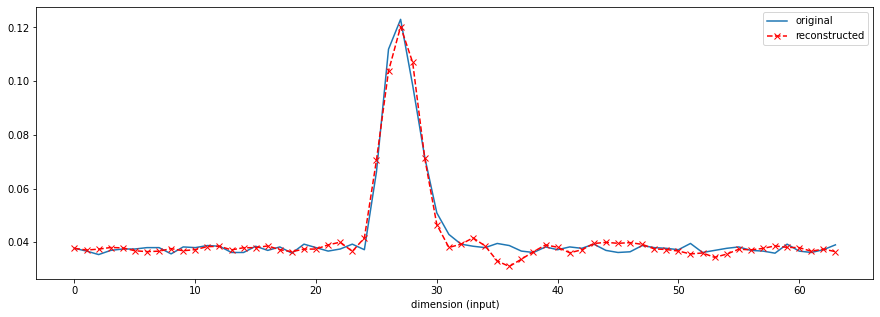

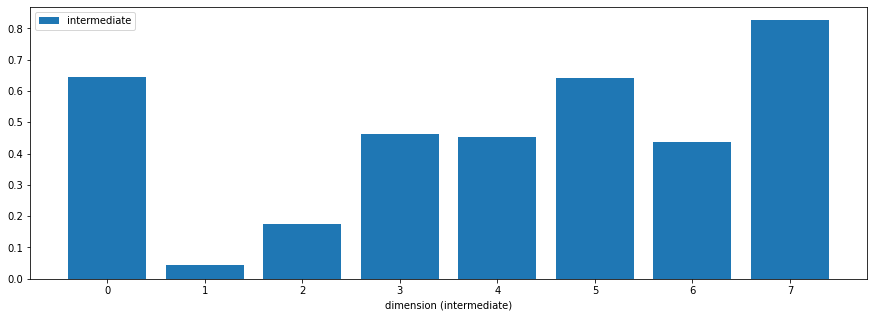

In [62]:
wf = dataset[9000]["waveform"]
xs = np.arange(len(wf))
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(xs,wf, label="original")
output = ac(wf.view(1,1,-1)).detach()
ax.plot(xs,output.view(-1), "x--r", label="reconstructed")
ax.set_xlabel("dimension (input)")
ax.legend()

fig, ax = plt.subplots(figsize=(15,5))
output = ac.encoder(wf.view(1,1,-1)).detach().view(-1)
xs = np.arange(output.shape[0])
ax.bar(xs,output,label="intermediate")
ax.set_xlabel("dimension (intermediate)")
ax.legend()

## Visualisierung in 2D/3D (bei entsprechender Zwischendimension

In [6]:
%matplotlib inline
if aedim == 3:
    encodings = ac.encoder(dataset[:]["waveform"]).detach()
    
    cov = np.matrix(np.cov(encodings.T))
    encodings = np.matmul(encodings, cov)
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    c = ((255*encodings[:,0])*2**16 + (255*encodings[:,1])*2**8 + (255*encodings[:,2]))/2**24
    ax.scatter(encodings[:,0], encodings[:,1], encodings[:,2], c=c, marker=".")
    ax.set_xlabel('h0')
    ax.set_ylabel('h1')
    ax.set_zlabel('h2')

if aedim == 2:
    encodings = ac.encoder(dataset[:]["waveform"]).detach()
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    c = ((255*encodings[:,0])*2**8 + (255*encodings[:,1]))/2**24
    ax.scatter(encodings[:,0], encodings[:,1], c=c, marker=".")
    ax.set_xlabel('h0')
    ax.set_ylabel('h1')

## K-Means auf Zwischenrepräsentationen

In [43]:
result = ac.encoder(dataset[:]["waveform"].unsqueeze(1)).detach()
result = result.view(result.size(0),-1).numpy()

In [25]:
# cov = np.matrix(np.cov(result.T))
# scale = np.linalg.cholesky(cov)
# result = np.matmul(result, cov)
# scale.shape

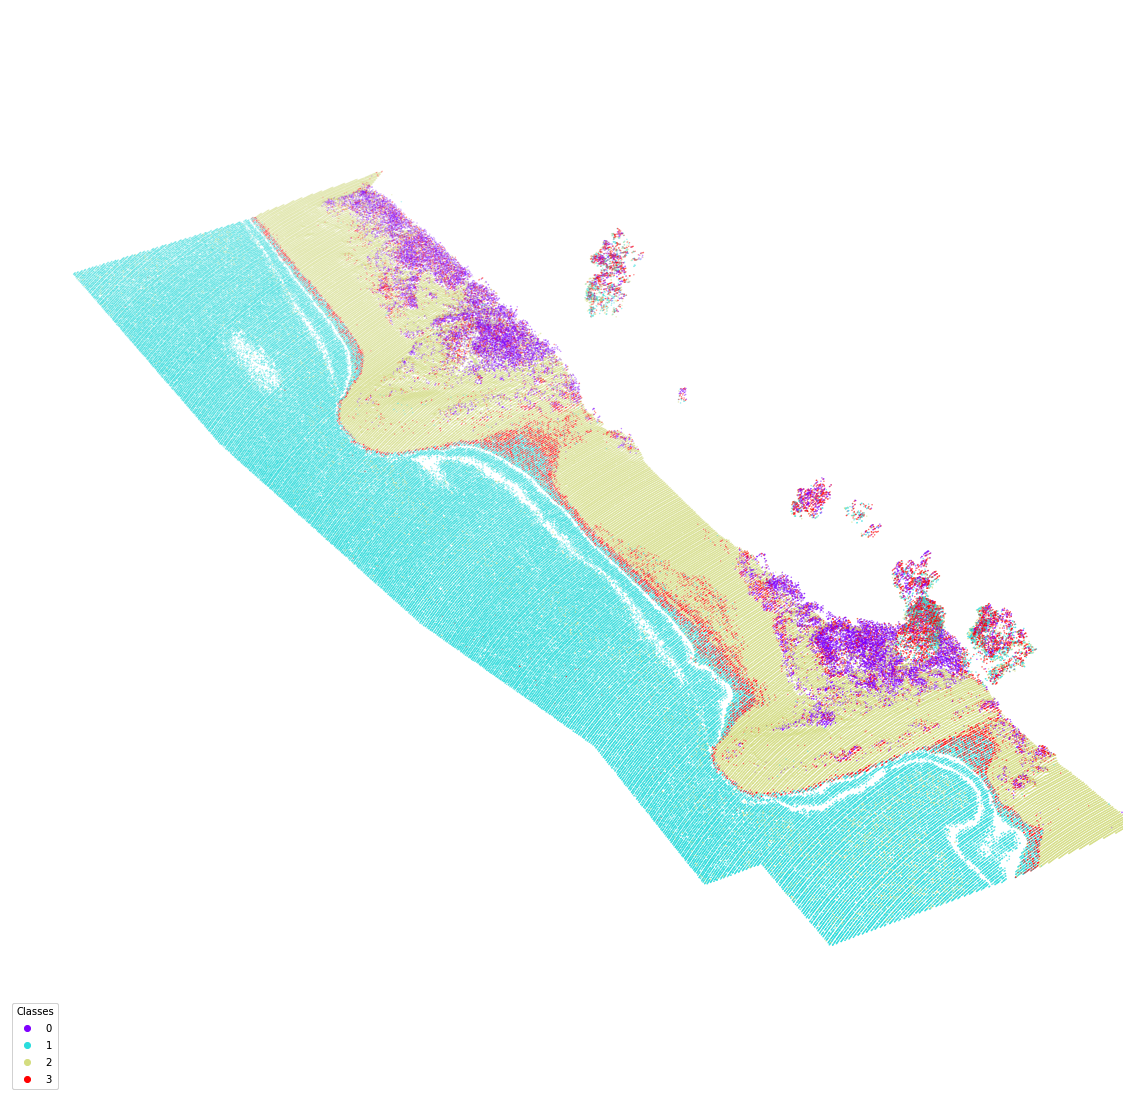

In [44]:
from scipy.cluster.vq import kmeans2
from itertools import product
clustercount = 4
initialcentroids = result[np.random.randint(len(result), size=clustercount)]
ks, labels = kmeans2(result, k=initialcentroids, minit="matrix")
import matplotlib.cm as cm
datapred = data.assign(prediction = labels)
utils.plot_pcl(datapred, targetcol="prediction")

## Visualisierung der Clusterzentren

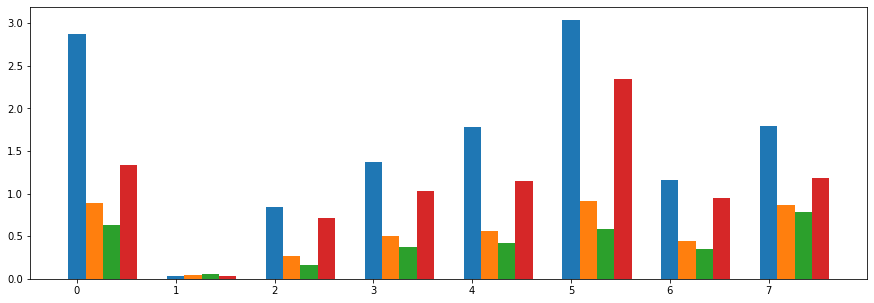

In [46]:
plt.figure(figsize=(15,5))
width = 0.35
# plt.axis("off")
for idx,k in enumerate(ks):
    # wf = ac.decoder(torch.tensor(k).unsqueeze(0)).view(-1).detach()
    plt.bar(np.arange(len(k)) + 2*width*(idx/len(ks)), k, 2*width/len(ks), label="centroid k=%d" % idx)
# plt.legend()